In [ ]:
#@title License and Disclaimer

'''
This project is intended to serve as an academic tutorial to help with research
efforts.

The DIV2K dataset is used here for demonstration purposes, and is cited below.

@InProceedings{Agustsson_2017_CVPR_Workshops,
	author = {Agustsson, Eirikur and Timofte, Radu},
	title = {NTIRE 2017 Challenge on Single Image Super-Resolution: Dataset and
  Study},
	booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition
  (CVPR) Workshops},
	month = {July},
	year = {2017}
}

DIV2K Quoted License: (source: https://data.vision.ee.ethz.ch/cvl/DIV2K/)
Please notice that this dataset is made available for academic research purpose
only. All the images are collected from the Internet, and the copyright belongs
to the original owners. If any of the images belongs to you and you would like
it removed, please kindly inform us, we will remove it from our dataset
immediately.

The following is in respect of the software portion of the material presented
here.

Copyright <2023> <Parham Faraji>

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the “Software”), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
'''

In [ ]:
#@title Data Import

import tensorflow as tf
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
train = tfds.load('div2k/bicubic_x8', split='train', shuffle_files=False)
test = tfds.load('div2k/bicubic_x8', split='validation', shuffle_files=False)

# Build your input pipeline
'''
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
for example in ds.take(1):
  image, label = example["image"], example["label"]
'''

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x8/2.0.0.incompleteL7QM7C/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x8/2.0.0.incompleteL7QM7C/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x8/2.0.0. Subsequent calls will reuse this data.


'\nds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)\nfor example in ds.take(1):\n  image, label = example["image"], example["label"]\n'

In [ ]:
#@title Packaging Function

import numpy as np
import cv2
from tqdm import tqdm

def normalize(cluster):
  # clusterNorm = (cluster - 127.5) / 127.5
  clusterNorm = cluster / 255
  del cluster
  return clusterNorm

def package(data, count):
  # dataset = dataset.take(3)
  # list(dataset.as_numpy_iterator())
  hr = []
  lr = []
  for image in tqdm(data.take(count)):
    imgh = image['hr']
    imgha = np.array(imgh)
    imghr = cv2.resize(imgha, (120*2, 120*2), interpolation = cv2.INTER_AREA)
    imglr = cv2.resize(imgha, (120, 120), interpolation = cv2.INTER_AREA)
    hr.append(imghr)
    lr.append(imglr)
    del imgh, imgha, imghr, imglr

  hr_out = normalize(np.array(hr))
  lr_out = normalize(np.array(lr))
  del lr, hr
  print(lr_out.shape, hr_out.shape)
  return lr_out, hr_out

In [ ]:
#@title Packaging Data
# del V, Yv, X, Yx
V, Yv = package(test, 100) #100
X, Yx = package(train, 800) #800
print(V.shape[1:], np.min(V), np.max(V))

100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


(100, 120, 120, 3) (100, 240, 240, 3)


100%|██████████| 800/800 [01:22<00:00,  9.75it/s]


(800, 120, 120, 3) (800, 240, 240, 3)
(120, 120, 3) 0.0 1.0


In [ ]:
#@title Layer Designer (2D) Function

from tensorflow import keras

# This approach helps make design intuitive, intelligible, and easy to alter
# No need to worry about the order of operations
# You simply enable certain sub-layers and focus on the grand architecture
# It is especially useful as a tool for beginners to start from the middle by fiddling around
# The "engage" variable in the function is responsible for enabling all operations needed for a composite layer
# Using default parameters, layers can be on autopilot by verifying input/"consign" alone
def layer2D_global(consign, engage=[1,0,0,1,0,0], fmaps=24, k=(3,3), act='relu', step=(1,1), pool=(2,2), scale=(2,2), dp=.20, ep=1e-5, pad='same'): # same/valid

  # preset-choices:
  if engage[0]==1:
    consign = keras.layers.Conv2D(filters=fmaps, kernel_size=k, strides=step, padding=pad)(consign)
  if engage[0]==2:
    consign = keras.layers.Conv2DTranspose(filters=fmaps, kernel_size=k, strides=step, padding=pad)(consign)
  if engage[0]==3:
    attn = keras.layers.MultiHeadAttention(num_heads=3, key_dim=fmaps)
    consign = attn(consign, consign)

  if engage[1]:
    consign = keras.layers.BatchNormalization()(consign)
  if engage[2]:
    consign = keras.layers.LayerNormalization(epsilon=ep)(consign)
  if engage[3]:
    consign = keras.layers.Activation(act)(consign)
  if engage[4]:
    consign = keras.layers.MaxPooling2D(pool)(consign)
  if engage[5]:
    consign = keras.layers.UpSampling2D(scale, interpolation='bicubic')(consign)
  if engage[6]:
    consign = keras.layers.Dropout(dp)(consign)

  return consign

# We could narrow down choices using a subset, for a simplified demonstration
def layer(input, engage, fmaps, k, act, step=(1,1), scale=(2,2), pad='same'): # same/valid
  conv = keras.layers.Conv2DTranspose(filters=fmaps, kernel_size=k, strides=step, padding=pad)(input)

  # preset-choices:
  if engage[0]:
    conv = keras.layers.BatchNormalization()(conv)
  if engage[1]:
    conv = keras.layers.Activation(act)(conv)
  if engage[2]:
    conv = keras.layers.UpSampling2D(scale, interpolation='bicubic')(conv)

  return conv


In [ ]:
#@title Upscaler Model Demo

'''Keep in mind upscalers are heavy, so be efficient with your design'''
def architect(preset=30, nc=3): # nc = number of output channels

  # lunch
  inputshape = [120,120,3]
  inputlayer = keras.layers.Input(inputshape)

  # independent-layers@lvl1
  l1a = layer(inputlayer, [1,1,0], fmaps=preset*2, k=(5,5), act='relu', step=(2,2))

  l1b = layer(inputlayer, [1,1,1], fmaps=preset*2, k=(4,4), act='relu', scale=(2,2))

  l1c = layer(inputlayer, [1,1,0], fmaps=preset,   k=(3,3), act='relu', step=(2,1))
  l1c = layer(l1c,        [1,1,0], fmaps=preset,   k=(3,3), act='relu', step=(1,2))

  # merge-1
  l1con = keras.layers.Concatenate()([l1a, l1b, l1c])
  l1con = keras.layers.BatchNormalization()(l1con)

  # independent-layers@lvl2
  l2a = layer(l1con, [1,1,0], fmaps=preset*2, k=(5,5), act='relu')

  l2b = layer(l1con, [1,1,0], fmaps=preset*2, k=(3,3), act='relu')

  # residual
  res = layer(inputlayer, [1,1,0], fmaps=preset, k=1, act='linear', step=(2,2))

  # merge-2
  l2con = keras.layers.Concatenate()([res, l2a, l2b])
  l2con = keras.layers.BatchNormalization()(l2con)

  # simplified-finalization
  l3 = layer(l2con, [1,1,0], fmaps=preset*2, k=(4,4), act='relu')
  l4 = layer(l3,    [1,1,0], fmaps=preset*3, k=(3,3), act='relu')
  outputlayer = layer(l4, [1,1,0], fmaps=nc,  k=1,  act='linear')

  return inputlayer, outputlayer


# tie generator
input, output = architect()
model = keras.models.Model(inputs=input, outputs=output)
assert model.output_shape == (None, 240, 240, 3)

# compile model
model.compile(loss='mae', optimizer=keras.optimizers.Adam())

# print model
model.summary()

# implement callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,
                patience=4, min_lr=1e-4)

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto',
                verbose=1, patience=20, restore_best_weights=True)

cp = keras.callbacks.ModelCheckpoint(
                './best_checkpoint', monitor="val_loss", verbose=0,
                save_best_only=True, save_weights_only=False, mode="auto",
                save_freq="epoch", initial_value_threshold=0.05) # *threshold based on a previous test run

# fit data into model
model.fit(x=X, y=Yx, batch_size=16, epochs=99, verbose=1, # *batch size based on available hardware
                validation_data=(V, Yv), shuffle=True,
                callbacks=[reduce_lr, es, cp]) # or [reduce_lr, es]

# Save model
model.save('NTU')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv2d_transpose_12 (Conv2  (None, 240, 120, 30)         840       ['input_2[0][0]']             
 DTranspose)                                                                                      
                                                                                                  
 batch_normalization_14 (Ba  (None, 240, 120, 30)         120       ['conv2d_transpose_12[0][0]'] 
 tchNormalization)                                                                                
                                                                                            

In [ ]:
#@title Sample Prediction with Best Weights

from tensorflow.keras.models import load_model
'''either load or use existing model'''
modelcp = load_model('/content/best_checkpoint')
predictions = modelcp.predict(V[:3])

1/1 [==============================] - 4s 4s/step


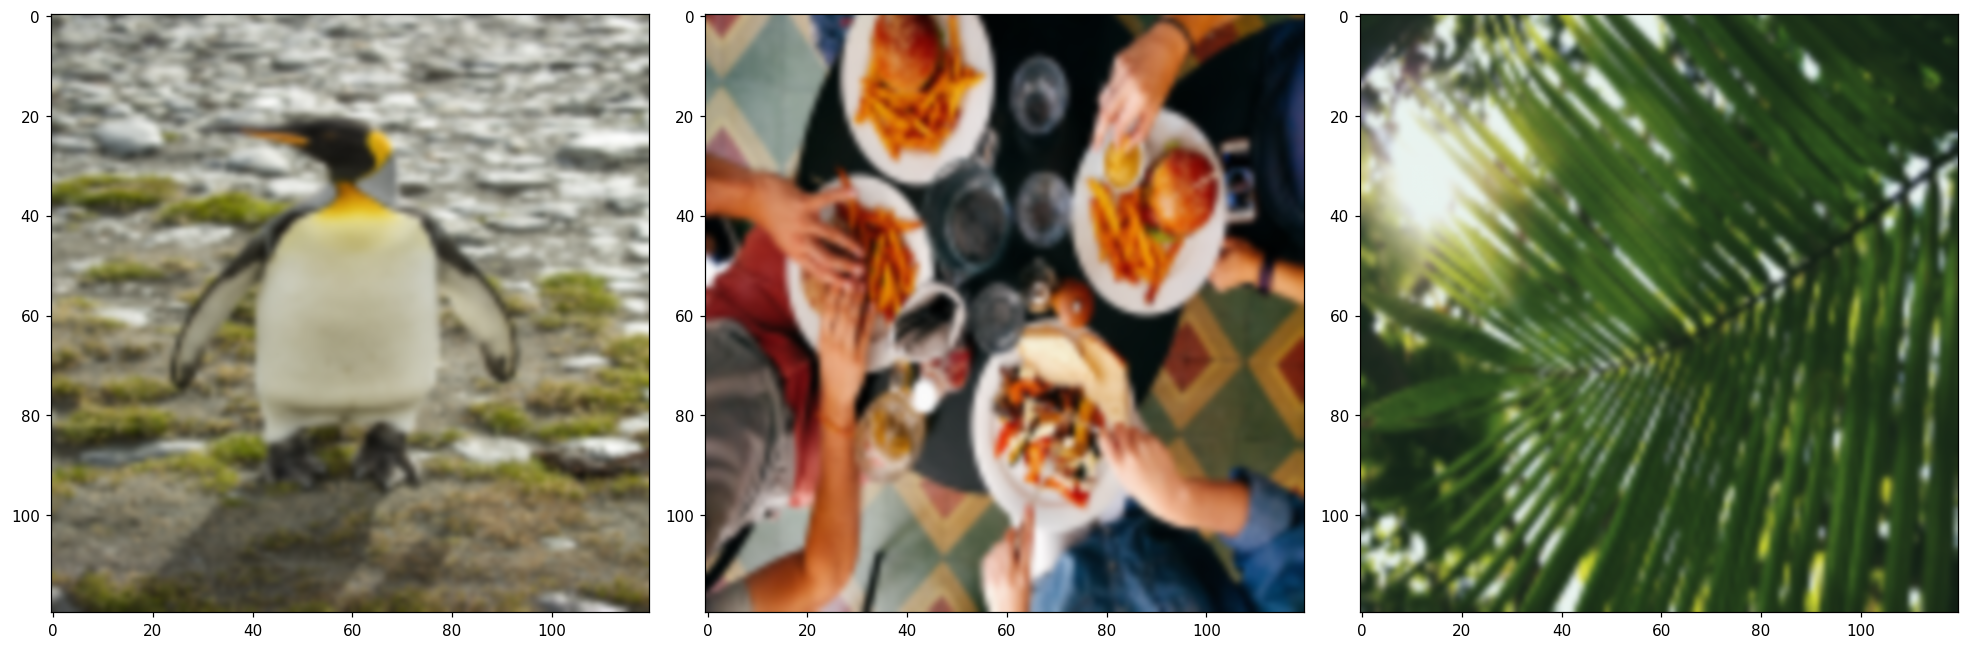

In [ ]:
#@title Visualize Bicubic

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 9), dpi=110)
for n in range(1,4):
  fig.add_subplot(1, 3, n)
  plt.imshow(V[n-1], interpolation='bicubic')

plt.tight_layout()
# plt.show()
plt.savefig('BicubicNTU.png', format='png')

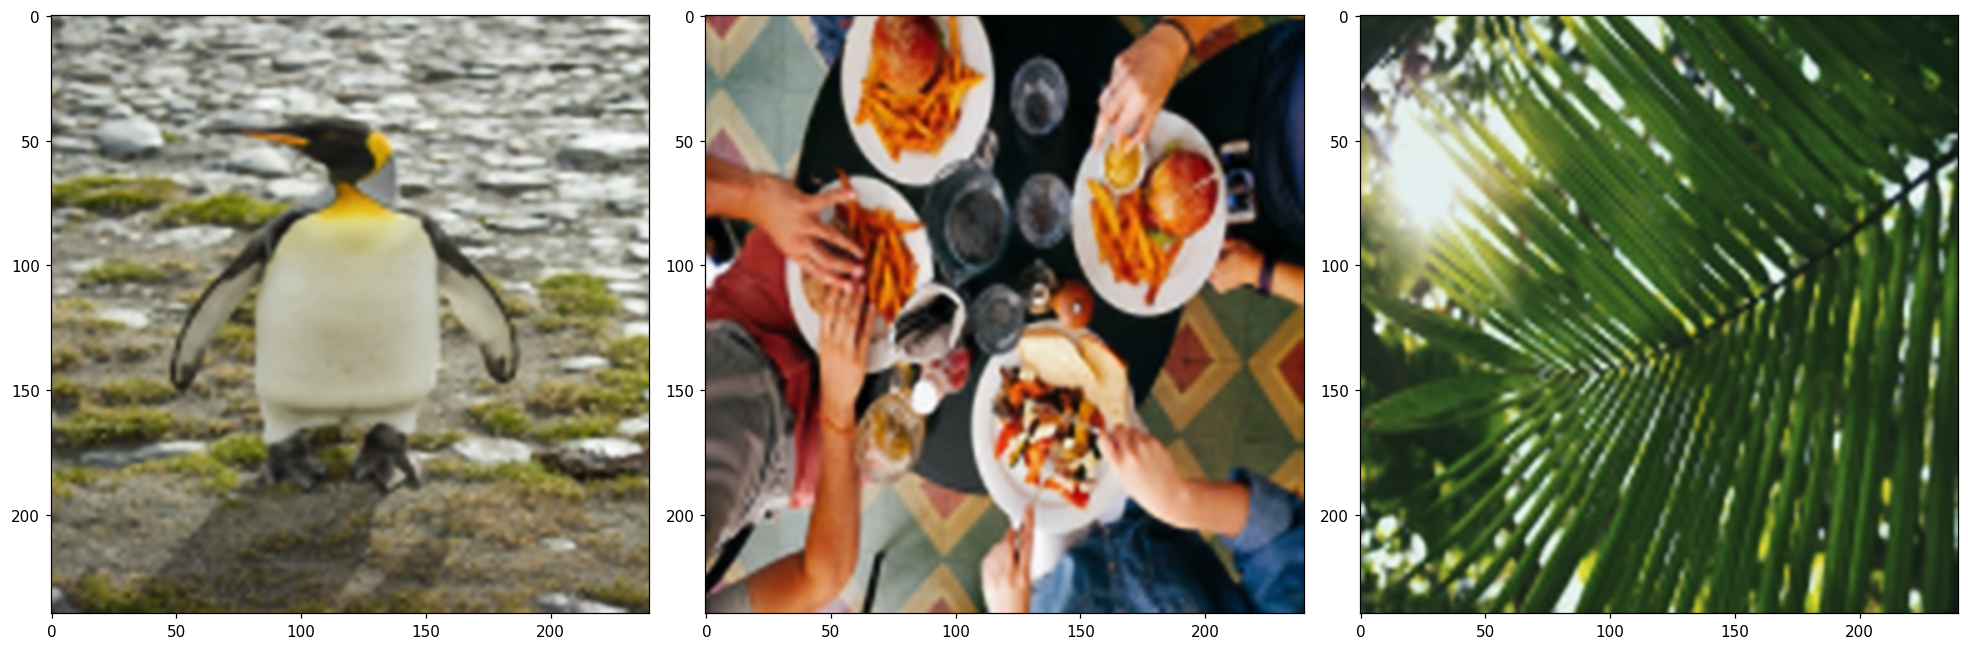

In [ ]:
#@title Visualize AI Upscaled

fig = plt.figure(figsize=(18, 9), dpi=110)
for n in range(1,4):
  fig.add_subplot(1, 3, n)
  plt.imshow(predictions[n-1], interpolation='bicubic')

plt.tight_layout()
# plt.show()
plt.savefig('UpscaledNTU.png', format='png')

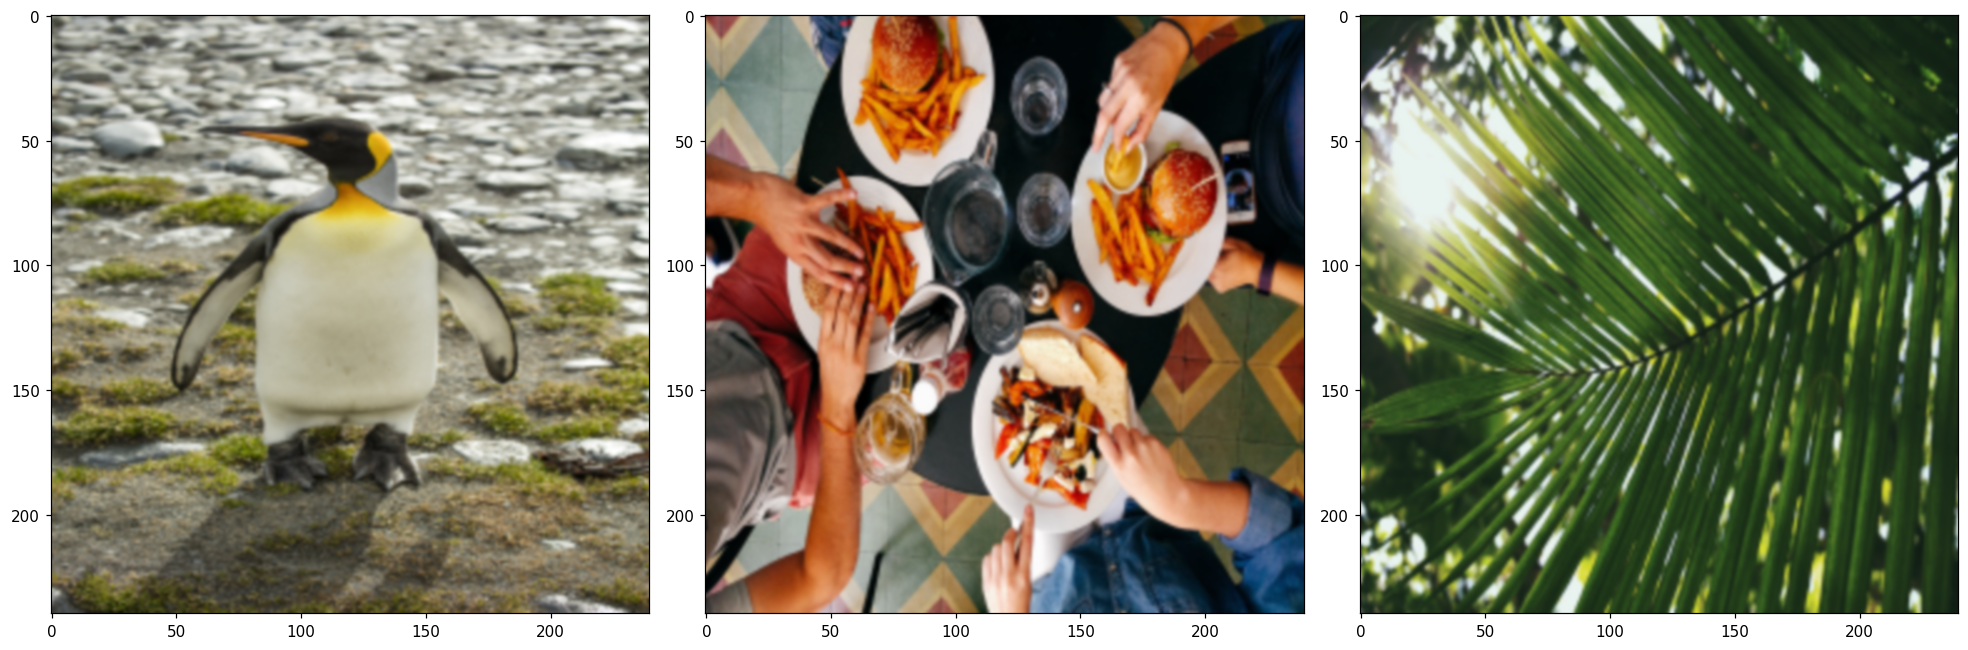

In [ ]:
#@title Visualize Target

fig = plt.figure(figsize=(18, 9), dpi=110)
for n in range(1,4):
  fig.add_subplot(1, 3, n)
  plt.imshow(Yv[n-1], interpolation='bicubic')

plt.tight_layout()
# plt.show()
plt.savefig('TargetNTU.png', format='png')

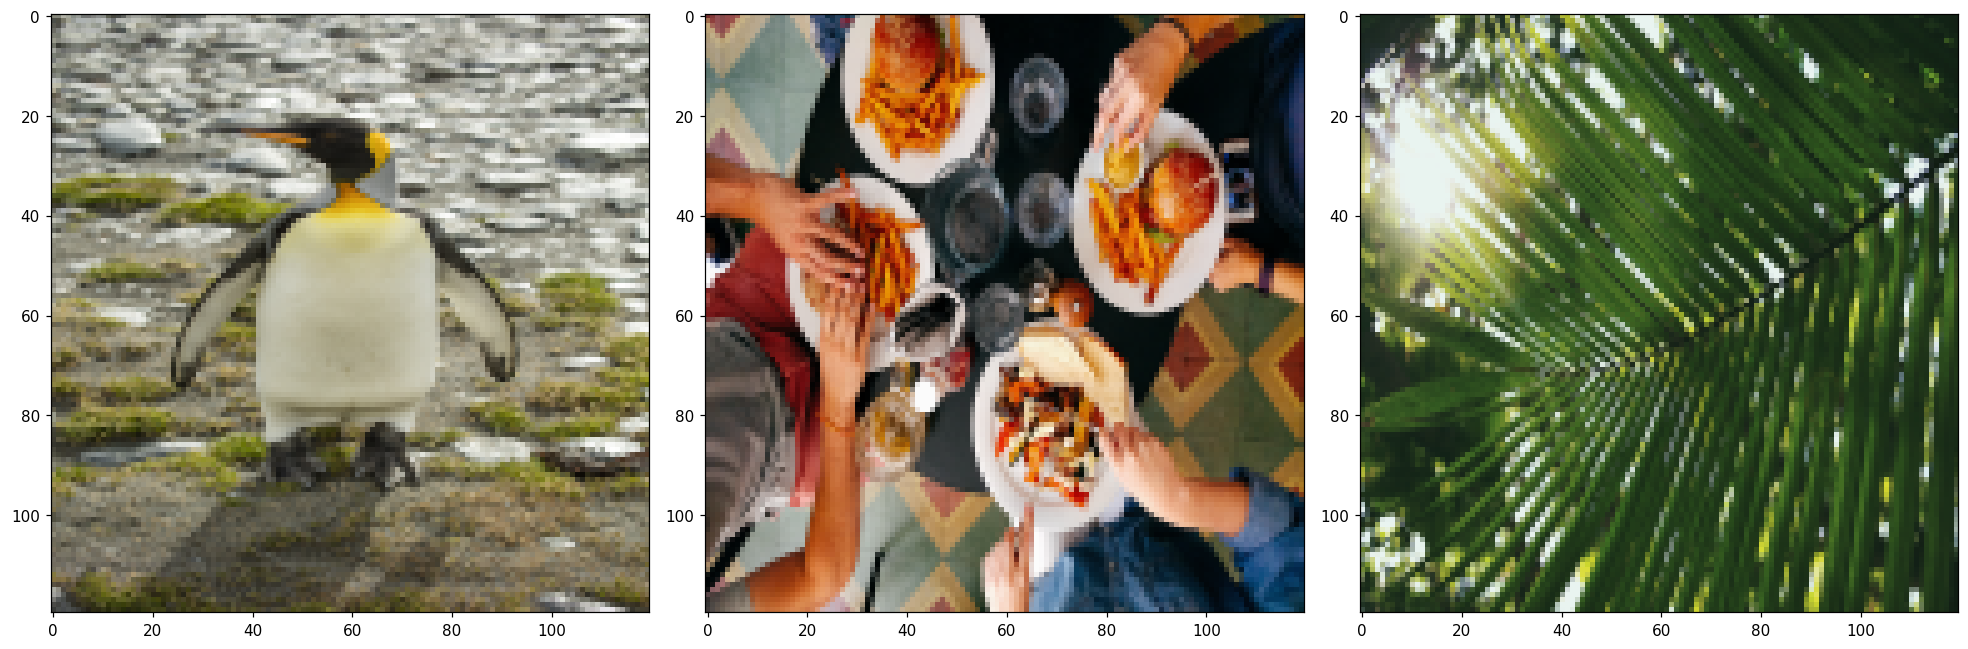

In [ ]:
#@title Visualize Original

fig = plt.figure(figsize=(18, 9), dpi=110)
for n in range(1,4):
  fig.add_subplot(1, 3, n)
  plt.imshow(V[n-1])

plt.tight_layout()
# plt.show()
plt.savefig('OriginalNTU.png', format='png')

In [ ]:
#@title Save Comparison Results

for n in range(3):
  cv2.imwrite("Upscaled"+str(n)+".png", cv2.resize(predictions[n,:,:,::-1]*255, (480,480), interpolation = cv2.INTER_CUBIC))
  cv2.imwrite("Target"+str(n)+".png", cv2.resize(Yv[n,:,:,::-1]*255, (480,480), interpolation = cv2.INTER_CUBIC))
  cv2.imwrite("Original"+str(n)+".png", cv2.resize(V[n,:,:,::-1]*255, (480,480), interpolation = cv2.INTER_NEAREST_EXACT))
  cv2.imwrite("Bicubic"+str(n)+".png", cv2.resize(V[n,:,:,::-1]*255, (480,480), interpolation = cv2.INTER_CUBIC))
